In [51]:
import numpy as np
import scipy.io
import pandas as pd
import json
from typing import List, Callable
import run_classifiers
import importlib
importlib.reload(run_classifiers)
import matplotlib.pyplot as plt
from tqdm import tqdm
import neuroCombat
from sklearn.preprocessing import StandardScaler

corrs_location = '../corrs'
A_mats_location = '../A_mats'

participants = pd.read_table('../SRPBS_OPEN/participants.tsv')
participants = participants.dropna()

train_sites = ['COI','KUT','SWA','UTO']
test_sites = ['ATT','ATV','CIN','HKH','HRC','HUH','KTT']

In [3]:
def participant_id_to_number(participant_id: str) -> int:
    return int(participant_id.split('-')[1])

def extract_participants_id(participants: pd.DataFrame, id: int) -> pd.DataFrame:
	return participants[[participant_id_to_number(name) == id for name in participants.participant_id.to_numpy()]]

def unpair(pairs: List[List[int]]) -> List[int]:
	return [id for pair in pairs for id in pair]

* 2 types of data (A matrices or correlations)
* 2 outlier choices (remove or not)
* 3 dataset subsets (all data, all pairs, perfect pairs)

In total - we have 2x2x3 = 12 datasets to feed into the classifiers

In [4]:
with open('../Dataset Analysis/dataset_all.txt','r') as f:
	ids_all_all = np.array(json.loads(f.read()))
with open('../Dataset Analysis/dataset_inliers.txt','r') as f:
	ids_inliers_all = np.array(json.loads(f.read()))
with open('../Dataset Analysis/all_pairs.txt','r') as f:
	ids_all_pairs = np.array(json.loads(f.read()))
with open('../Dataset Analysis/all_inliers_pairs.txt','r') as f:
	ids_inliers_pairs = np.array(json.loads(f.read()))
with open('../Dataset Analysis/all_perfect_pairs.txt','r') as f:
	ids_all_perfectpairs = np.array(json.loads(f.read()))
with open('../Dataset Analysis/all_inliers_perfect_pairs.txt','r') as f:
	ids_inliers_perfectpairs = np.array(json.loads(f.read()))

dataset_types = {
	'all': ids_all_all, 
	#'inliers': ids_inliers_all, 
	# 'all_pairs': ids_all_pairs,
	# 'inliers_pairs': ids_inliers_pairs, 
	# 'all_perfectpairs': ids_all_perfectpairs, 
	# 'inliers_perfectpairs': ids_inliers_perfectpairs
}

In [5]:
def read_correlation(subject: int) -> np.ndarray:
	return np.nan_to_num(scipy.io.loadmat(f'{corrs_location}/correlation_components_{subject:04d}.mat')['corr_components'].reshape(1,-1))

def read_A_matrix(subject: int) -> np.ndarray:
	return scipy.io.loadmat(f'{A_mats_location}/dcm_A_{subject:04d}.mat')['A'].reshape(1,-1)

load_data_functions = {'corr': read_correlation, 'Amat': read_A_matrix}

In [6]:
def harmonise_data(X_train, X_test, ids_train, ids_test, participant_data, regress_all=False):
    #protocol
    protocol_train = [int(participant.protocol.to_numpy()) for participant, is_train in zip(participant_data, ids_train) if is_train]
    protocol_test = [int(participant.protocol.to_numpy()) for participant, is_test in zip(participant_data, ids_test) if is_test]
    #age
    age_train = [int(participant.age.to_numpy()) for participant, is_train in zip(participant_data, ids_train) if is_train]
    age_test = [int(participant.age.to_numpy()) for participant, is_test in zip(participant_data, ids_test) if is_test]
    #sex
    sex_train = [int(participant.sex.to_numpy()) for participant, is_train in zip(participant_data, ids_train) if is_train]
    sex_test = [int(participant.sex.to_numpy()) for participant, is_test in zip(participant_data, ids_test) if is_test]
    #hand
    hand_train = [int(participant.hand.to_numpy()) for participant, is_train in zip(participant_data, ids_train) if is_train]
    hand_test = [int(participant.hand.to_numpy()) for participant, is_test in zip(participant_data, ids_test) if is_test]

    covars = pd.DataFrame(np.array([protocol_train+protocol_test, age_train+age_test, sex_train+sex_test, hand_train+hand_test]).T, columns=['protocol', 'age', 'sex', 'hand'])
    X = np.vstack((X_train, X_test))

    print("Harmonising protocol")
    harmonised_result = neuroCombat.neuroCombat(X.T, covars, batch_col='protocol', categorical_cols=['sex','hand'], continuous_cols=['age'])
    if regress_all:
        print("Harmonising sex")
        harmonised_result = neuroCombat.neuroCombat(harmonised_result['data'], covars, batch_col='sex', categorical_cols=['hand'], continuous_cols=['age'])
        print("Harmonising hand")
        harmonised_result = neuroCombat.neuroCombat(harmonised_result['data'], covars, batch_col='hand', continuous_cols=['age'])
        #print("Harmonising age")
        #harmonised_result = neuroCombat.neuroCombat(harmonised_result['data'], covars, batch_col='age')
    #protocols_test = np.array(protocol_, dtype='object')[:,0] # need this to make it the right format...
    #harmonised_result_test = neuroCombat.neuroCombatFromTraining(X_test.T, protocol_test, harmonised_result['estimates'])

    X_train = harmonised_result['data'][:, ids_train].T
    X_test = harmonised_result['data'][:, ids_test].T

    return X_train, X_test

In [7]:
def load_dataset(ids: np.ndarray, load_data_function: Callable[[int], np.ndarray], harmonise=True, standardise=False):#, harmonise: True):
	if ids.ndim == 1: # single list of participants
		participant_data = [extract_participants_id(participants, id) for id in ids]
	else: # pairs of participants
		participant_data = [extract_participants_id(participants, id) for pair in ids for id in pair]
		ids = ids.flatten()
	participants_train = [participant.site.to_numpy() in train_sites for participant in participant_data]
	participants_test = [participant.site.to_numpy() in test_sites for participant in participant_data]
	X_train = np.vstack([load_data_function(id) for id in ids[participants_train]])
	X_test = np.vstack([load_data_function(id) for id in ids[participants_test]])

	if harmonise:
		X_train, X_test = harmonise_data(X_train, X_test, participants_train, participants_test, participant_data, regress_all=True)

	if standardise: 
		scalar = StandardScaler()
		scalar.fit(X_train)
		X_train = scalar.transform(X_train)
		X_test = scalar.transform(X_test)

	labels = np.array(list(map(lambda participant: int(participant.diag // 2), participant_data)))
	Y_train = labels[participants_train]
	Y_test = labels[participants_test]

	return X_train, X_test, Y_train, Y_test

In [8]:
datasets = []

for dataset_name, ids in tqdm(dataset_types.items()):
	for function_name, load_data_function in load_data_functions.items():
		#if function_name == "corr":
		datasets.append([f'{dataset_name}_{function_name}', *load_dataset(ids, load_data_function, standardise=True, harmonise=False)])
		#datasets.append([f'{dataset_name}_{function_name}', *load_dataset(ids, load_data_function)])

100%|██████████| 1/1 [00:28<00:00, 28.37s/it]


In [9]:
for dataset in datasets:
	train_proportion = 100*dataset[3].shape[0]/(dataset[3].shape[0] + dataset[4].shape[0])
	test_proportion = 100*dataset[4].shape[0]/(dataset[3].shape[0] + dataset[4].shape[0])
	print(f'{dataset[0]}: (total - {dataset[3].shape[0] + dataset[4].shape[0]})\n\ttrain - [X: {dataset[1].shape}, Y: {dataset[3].shape}] ({train_proportion:.1f}%)\n\ttest -  [X: {dataset[2].shape}, Y: {dataset[4].shape}] ({test_proportion:.1f}%)')
for dataset_name, ids in dataset_types.items():
	print(f'{dataset_name} has {ids.size} participants')

all_corr: (total - 1043)
	train - [X: (626, 70876), Y: (626,)] (60.0%)
	test -  [X: (417, 70876), Y: (417,)] (40.0%)
all_Amat: (total - 1043)
	train - [X: (626, 142129), Y: (626,)] (60.0%)
	test -  [X: (417, 142129), Y: (417,)] (40.0%)
all has 1043 participants


In [36]:
scores = run_classifiers.run_classifiers(datasets, num_outer=10, num_inner=10)
np.save('100_clf_allscores_corr_amat_norm_lr', scores)

Processing dataset all_corr
... with Lasso_cv classifier
Running outer loop 0
Running subsample 0
alpha validation scores = [0.7589743589743589, 0.7626780626780627, 0.7740740740740741, 0.7747863247863249], best alpha = 1.0
[[0.23084906 0.76915094]
 [0.1100201  0.8899799 ]
 [0.10402042 0.89597958]
 [0.62262867 0.37737133]
 [0.00131411 0.99868589]
 [0.70576045 0.29423955]
 [0.97389612 0.02610388]
 [0.52408631 0.47591369]
 [0.29007957 0.70992043]
 [0.04715064 0.95284936]]
[[False  True]
 [False  True]
 [False  True]
 [ True False]
 [False  True]
 [ True False]
 [ True False]
 [ True False]
 [False  True]
 [False  True]]


ValueError: Classification metrics can't handle a mix of multilabel-indicator and binary targets

In [20]:
scores_test = np.load('100_clf_allscores_corr_amat_norm_lr.npy', allow_pickle=True).flat[0]
#scores_rf = np.load('100_clf_scores_corr_norm_svm_ranfor.npy', allow_pickle=True).flat[1]

In [50]:
mum = [[0.23084906, 0.76915094],
 [0.1100201,  0.8899799 ],
 [0.10402042, 0.89597958],
 [0.62262867, 0.37737133],
 [0.00131411, 0.99868589],
 [0.70576045, 0.29423955],
 [0.97389612, 0.02610388],
 [0.52408631, 0.47591369],
 [0.29007957, 0.70992043],
 [0.04715064, 0.95284936]]
print(np.array(mum)[:,0])

[0.23084906 0.1100201  0.10402042 0.62262867 0.00131411 0.70576045
 0.97389612 0.52408631 0.29007957 0.04715064]


In [26]:
scores_df = pd.DataFrame(scores_test)
scores_df

,all_corr,all_Amat
Lasso_cv Training Accuracy,0.71885,0.72524
Lasso_cv Training Balanced Accuracy,0.816667,0.820833
Lasso_cv Training F1 Score,0.623932,0.62931
Lasso_cv Testing Accuracy,0.527578,0.489209
Lasso_cv Testing Balanced Accuracy,0.5558,0.567388
Lasso_cv Testing F1 Score,0.397554,0.419619
Lasso_cv All Testing Accs,"[0.5323741007194245, 0.5059952038369304, 0.479...","[0.5155875299760192, 0.486810551558753, 0.5011..."
Lasso_cv All Testing Balanced Accs,"[0.5329637467795363, 0.5172306486561247, 0.525...","[0.5413740990467333, 0.55909226709157, 0.57170..."
Lasso_cv All Testing F1 Scores,"[0.3809523809523809, 0.3641975308641975, 0.385...","[0.3988095238095238, 0.42473118279569894, 0.43..."
Lasso_cv All Probabilities,"[[1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1,...","[[0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0,..."


In [33]:
scores_corr = scores_test['all_corr']
len((scores_test['all_corr']['Lasso_cv All Probabilities'][2]))

417

In [32]:
scores_df.filter(regex='.*Testing Balanced.*', axis='index')

,all_corr
Lasso_cv Testing Balanced Accuracy,0.466299


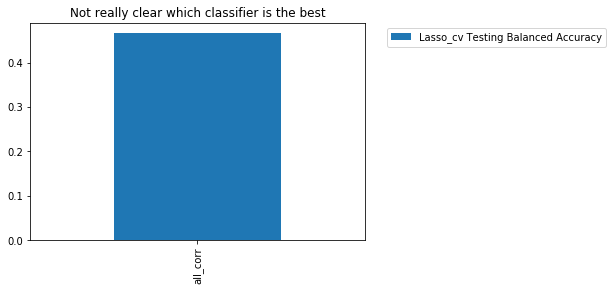

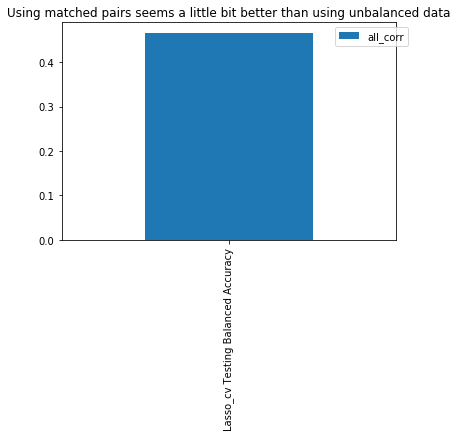

In [33]:
scores_df.filter(regex='.*Testing Balanced.*', axis='index').T.plot(kind='bar')
plt.title('Not really clear which classifier is the best')
plt.legend(bbox_to_anchor=(1.05,1))
plt.show()

scores_df.filter(regex='.*Testing Balanced.*', axis='index').plot(kind='bar')
plt.title('Using matched pairs seems a little bit better than using unbalanced data')
plt.legend(bbox_to_anchor=(1.05,1))
plt.show()